## 12.2 Convolutional Neural Network

In exercise 12.1, we considered images as 1-D vectors of 28 × 28 = 784 pixels. However, it would be certainly useful to leverage translational invariance and local spatial correlations that we expect to find in handwritten digit images. This characteristic can be achieved using convolutional layers. In addition to these, we use filters (MaxPooling) that reduce the dimensionality of the original image. A combination of these types of layers should be able to identify spatial patterns that characterize written digits.

The processed data is then transformed into a 1-D vector through the Flatten layer and further analyzed by the rest of the network. The last layer will necessarily contain 10 neurons (output). Being notably efficient in classification problems, the activation function for the last layer is usually softmax. With a network of this type, we should be able to increase accuracy compared to the non-convolutional networks considered so far.

The detailed structure is schematized below:

- Convolutional layer with 10 filters (it's necessary that they are the same number as possible outputs)
- Pooling layer
- Convolutional layer with 10 filters
- Flattening layer
- Dense all-to-all layer of 20 neurons
- Dense all-to-all layer of 20 neurons
- Dropout layer (with 50% probability)
- Dense all-to-all output layer

The convolutional and dense layers (except the last one) have a ReLU activation function. We chose the SGD optimizer and 8 epochs to train the algorithm.

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)
def printscore(score):
    print('*******************************************************')
    print('Model performance:')
    print('– Test loss:', score[0])
    print('– Test accuracy:', score[1])
    print('*******************************************************')

2024-07-11 23:51:12.646020: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 23:51:12.689176: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 23:51:12.707817: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 23:51:12.753671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 23:51:12.830610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [3]:
#load and process the data
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [4]:
# reshaping for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [5]:
#building the CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))

    model.add(MaxPool2D(pool_size=(3,3),strides=1))
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax')) #output layer
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [6]:
#Training the model

# training parameters
batch_size = 32
epochs = 8

# create the deep conv net
model_CNN=create_CNN()

model_CNN.summary()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

/home/scoffolale/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 10)     │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 10)     │         2,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        64,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,220 (266.48 KB)

 Trainable params: 68,220 (266.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.4898 - loss: 1.4068 - val_acc: 0.9425 - val_loss: 0.2043
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8008 - loss: 0.5462 - val_acc: 0.9636 - val_loss: 0.1256
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8450 - loss: 0.4221 - val_acc: 0.9732 - val_loss: 0.0928
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8676 - loss: 0.3635 - val_acc: 0.9768 - val_loss: 0.0781
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8708 - loss: 0.3426 - val_acc: 0.9763 - val_loss: 0.0771
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8804 - loss: 0.3224 - val_acc: 0.9810 - val_loss: 0.0668
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.8912 - loss: 0.3025 - val_acc: 0.9849 - val_loss: 0.0601
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.8974 - loss: 0.2844 - val_acc: 0.9854 - val_loss: 0.0589


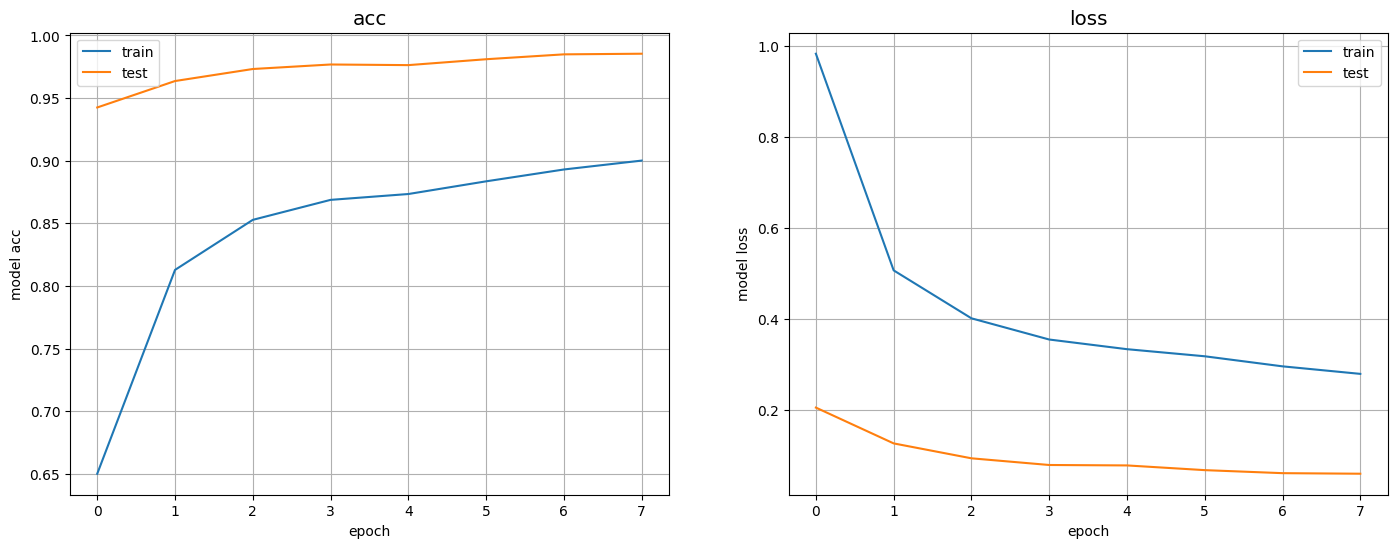

*******************************************************
Model performance:
– Test loss: 0.05889478325843811
– Test accuracy: 0.9854000210762024
*******************************************************
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


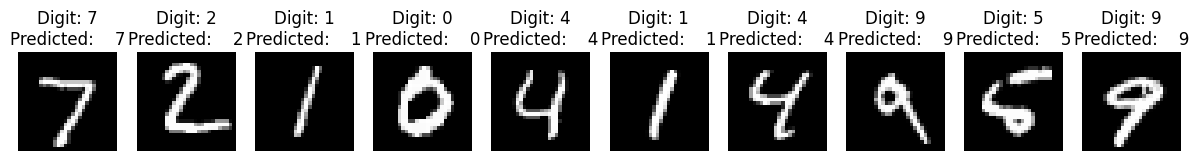

In [7]:
###### PERFORMANCE ##########################################
plt.rcParams['figure.figsize'] = [17, 6]
fig, ax = plt.subplots(1,2)

hist=['acc', 'loss'] 
val_hist=['val_acc', 'val_loss']

# summarize history for accuracy and loss
for i in range(2):
    ax[i].plot(history.history[hist[i]])
    ax[i].plot(history.history[val_hist[i]])
    ax[i].set_ylabel('model '+hist[i])
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'test'], loc='best')
    ax[i].grid()
    ax[i].set_title(hist[i], size='x-large')
plt.show()

score = model_CNN.evaluate(X_test, Y_test, verbose=0)
printscore(score)

predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

A significant improvement in test data accuracy is observed, demonstrating the effectiveness of the dropout layer. Additionally, all digits have been correctly classified.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


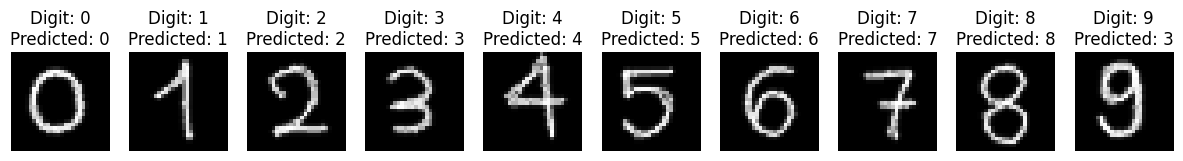

In [9]:
from PIL import Image
    
plt.figure(figsize=(15,15))

for d in range(10): 
    digit_filename = ""+str(d)+".png"
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    #print("Image size: "+str(xdim)+"x"+str(ydim))
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]
    data /= 255
    ax = plt.subplot(3, 10, d + 1) 
    plt.imshow(data, cmap='gray')
    #plt.imshow(X_test[i, :, :, 0], cmap='gray') 
    data = data.reshape(1, img_rows, img_cols, 1)
    prediction=model_CNN.predict(data)
    plt.title("Digit: "+str(d)+"\nPredicted: "+str(np.argmax(prediction)))   
    plt.axis('off') 
plt.show()